In [32]:
# pip install python-louvain
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx 
from matplotlib.animation import *
from tqdm import tqdm
from numba import njit
from networkx.algorithms import community
import pandas as pd

plt.rcParams["figure.figsize"] = [14, 8]
plt.rcParams["figure.dpi"] = 100
plt.set_cmap("binary_r")

<Figure size 1400x800 with 0 Axes>

In [56]:
def read_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    return lines

def find_index(lst):
    return int(lst[-2])

def find_name(lst):
    return lst[-1]

def find_edges(lst):
    # Split each string in the list by whitespace, convert to integers, and store in a new list
    processed_lst = [list(map(int, item.strip().split())) for item in lst]
    return np.array(processed_lst)

yeast = read_file('LAB3-data/YeastS.net') # list of strings, 2361 vertices
yeast = yeast[12:]
N_vertices = 2361 

vertices = np.array([find_index(yeast[i].split(" ")) for i in range(N_vertices)]) # equivalent to np.arange(1, 2361+1)
names = [find_name(yeast[i].split(" ")) for i in range(N_vertices)] 
names = [name[1:-2] for i, name in enumerate(names)] # Names of the vertices ['YBR236C', 'YOR151C', 'YML010W', ...]

edges = find_edges(yeast[N_vertices+1:]) - 1 # egdes of the graph, subtracting 1 so the indices starts with 0

"""
I assume that the edges represent some sort of bidirectional relation between different kind of yeast, 
the graph should therefore be undirected. To compensate this, I add additional edges to the graph to make it 'undirected'.
It wont affect the visualization.
"""
#edges = np.concatenate([edges, edges[:,::-1]], axis=0)
N_edges = len(edges)

@njit
def construct_adj_matrix(
    edges, 
    A = np.zeros([N_edges, N_edges], dtype=int)):
    
    col1, col2 = edges.T
    for i in col1:
        for j in col2:
            A[i,j] = 1          
    return A

# Constructing the adjacency matrix
adj_matrix = construct_adj_matrix(edges)

# Visualizing the graph

One way to do this is to check the adjacency matrix. It looks like only the first 2361 vertices are relevant.

2361.0


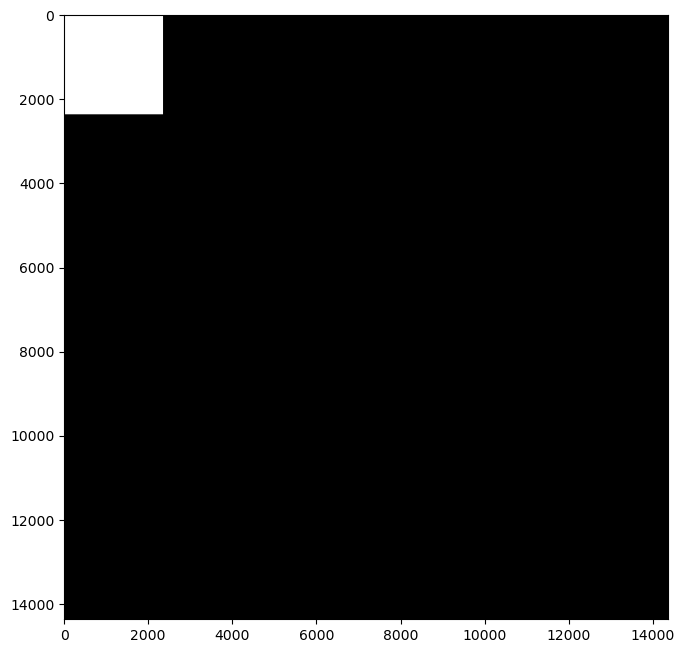

In [18]:
plt.imshow(adj_matrix)
print(np.sqrt(np.count_nonzero(adj_matrix))) 

For visualization porpurses, I will only look at the first N cases. For N = 200, there seems to be around 11 clusters if we ignore the single separated vertex.

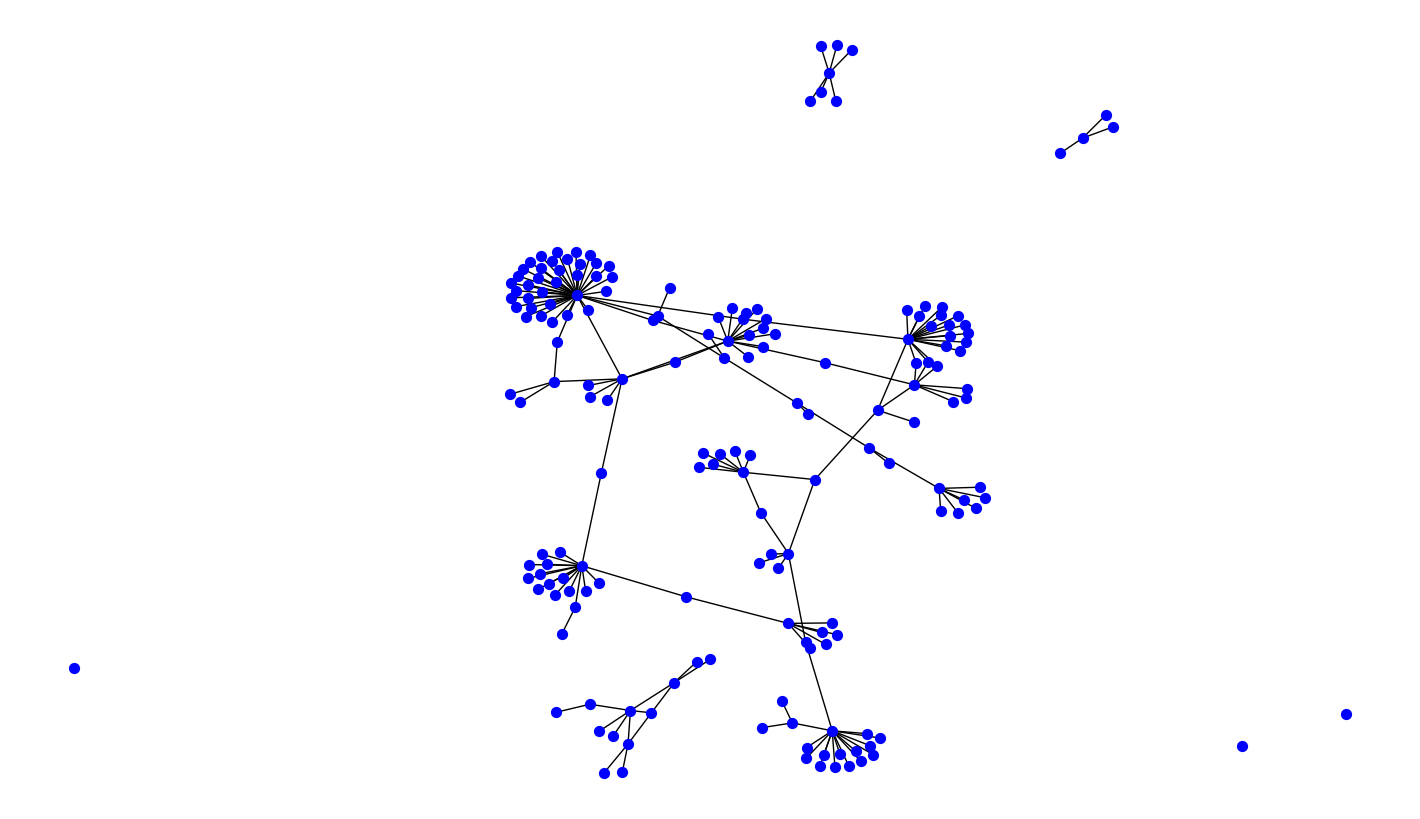

In [62]:
N = 200
edges_subset = edges[:N]
names_subset = names[:N]

G = nx.Graph()
for edge in edges_subset:
    G.add_edge(edge[0], edge[1])

unique_nodes = np.unique(edges_subset)
name_mapping = dict(zip(unique_nodes, names[:len(unique_nodes)]))

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=False, node_size=50, node_color="blue", font_weight='bold')
# nx.draw_networkx_labels(G, pos, labels=name_mapping, font_size=8) # optional labels of the vertices (messy if N > 100)
plt.show()

# Computing the modularity of the subgraph (N=200)
I used the Girvan-Newman algorithm for determining the set of all possible ways the graph can be partitioned.
The algorithm works by iterating through each possible partiotion, then for each partition it computes the corresponding modularity.
After looping through all the partition configurations, the algorithm finds the the partition that have the largest modularity and returns a list of sets of cluster indices i.e. [cluster_1, cluster_2, ..., cluster_n]. 
Note that this is a brute force algorithm that only works on smaller graphs.

In [83]:
def compute_modularity(G, clusters):
    total_edges = 2 * G.number_of_edges() # times 2 to get an undirected graph (the original graph is a directed graph)
    modularity = 0

    # Iterate over each cluster
    for cluster in clusters:
        # Calculate e_ii and a_i for the current cluster
        volume = 0 # sum of degrees of the cluster
        e = 0 # edges in a cluster
        
        for node_i in cluster:
            for node_j in cluster:
                if G.has_edge(node_i, node_j):
                    e += 1 if node_i != node_j else 0 # asssuming the vertices have no self loop

        # Calculate a_i separately
        for node in cluster:
            volume += G.degree(node)
        
        # Update modularity
        modularity += e / total_edges - volume**2 / (4 * total_edges**2)

    return modularity


# The Girvan-Newman algorithm returns an iterator of sets of nodes in each cluster
girvan_newman_clusters = community.girvan_newman(G)

def find_best_girvan_newman_clustering(G, clusters_iter):
    best_clusters = []
    # Setting it to zero by assuming that the graph is initialized to be random.
    best_modularity = 0 

    for clusters in clusters_iter:
        modularity_value = compute_modularity(G, clusters) # Computing Q
        # When a better modularity (Q) is found, then it will get replaced by the higher value of Q.
        if modularity_value >= best_modularity:
            best_modularity = modularity_value # Replaces the previously smallest Q
            best_clusters = clusters # Accepts a cluster if the Q increases

    return best_clusters, best_modularity

best_clusters, best_modularity = find_best_girvan_newman_clustering(G, girvan_newman_clusters)
num_clusters = len(best_clusters)

print("Number of clusters:", num_clusters)
print("Modularity:", best_modularity)

Number of clusters: 11
Modularity: 0.83455625


The modularity is close to 1 which indicates that it is "obvious" that there are clusters in the graph. 

# Generating a random graph

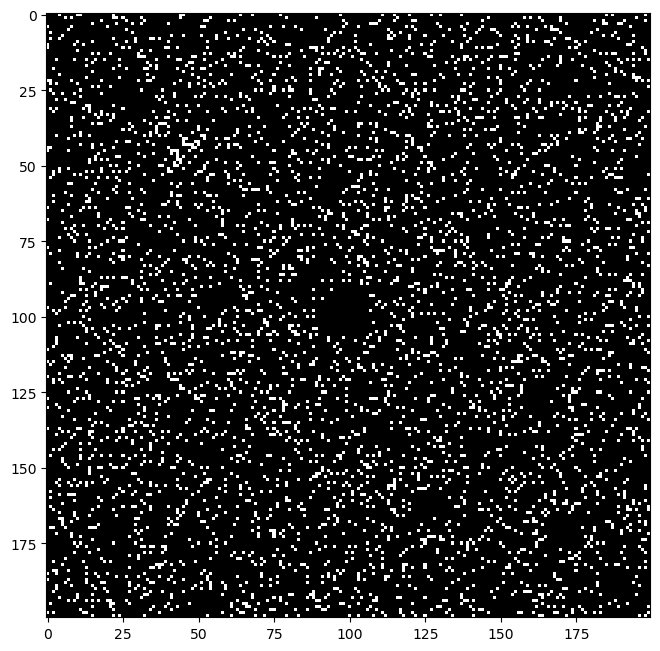

In [7]:
def generate_er_graph(n, p):
    A = np.zeros((n, n), dtype=int)
    
    for i in range(n):
        for j in range(i+1, n):
            r = np.random.rand()
            if r < p:
                A[i, j] = 1
                A[j, i] = 1
                
    return A

n = 200 # number fo vertices
p = 0.1 # probability

adj_matrix = generate_er_graph(n, p)
plt.imshow(adj_matrix)